<a href="https://colab.research.google.com/github/insoucyant/MachineLearning/blob/main/TransformerTSUnivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Note: using Google CoLab
Using device: cpu


In [17]:
# https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_3_transformer_timeseries.ipynb
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
col_names = ["year","month","day","dec_year", "sn_value", "sn_error", "obs_num", "unused"]
df = pd.read_csv("https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
                 sep=";", header=None, names=col_names,
                 na_values=['-1'], index_col=False)
print(df.dtypes)
df.head()

year          int64
month         int64
day           int64
dec_year    float64
sn_value      int64
sn_error    float64
obs_num       int64
unused        int64
dtype: object


,year,month,day,dec_year,sn_value,sn_error,obs_num,unused
0,1818,1,1,1818.001,-1,NaN,0,1
1,1818,1,2,1818.004,-1,NaN,0,1
2,1818,1,3,1818.007,-1,NaN,0,1
3,1818,1,4,1818.010,-1,NaN,0,1
4,1818,1,5,1818.012,-1,NaN,0,1


# Data Preprocessing

In [3]:
start_id = max(
    df[df['obs_num']==0].index.tolist()
)+1
print(f"Start Id is: {start_id}")
df = df[start_id:].copy(deep=True)
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year']<2000]
df_test = df[df['year']>=2000]
print(f"Training set size: {df_train.shape}")
print(f"Test set size: {df_test.shape}")

Start Id is: 11314
Training set size: (55160, 8)
Test set size: (6391, 8)


In [4]:
spots_train = df_train['sn_value'].to_numpy().reshape(-1,1)
spots_test = df_test['sn_value'].to_numpy().reshape(-1,1)



1.Fit(): Method calculates the parameters μ and σ and saves them as internal objects.

2.Transform(): parameters generated from fit() method,applied upon model to generate transformed data set.

3.Fit_transform(): combination of fit() and transform() api on same data set

est.fit_transform(X) is always equivalent to est.fit(X).transform(X), but usually faster.


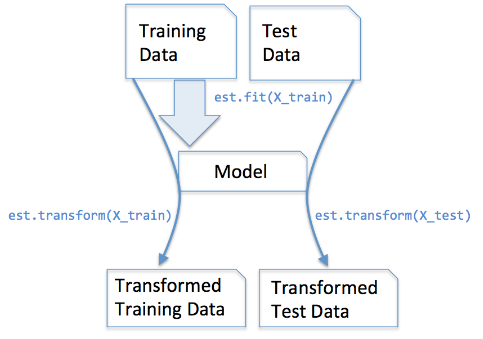

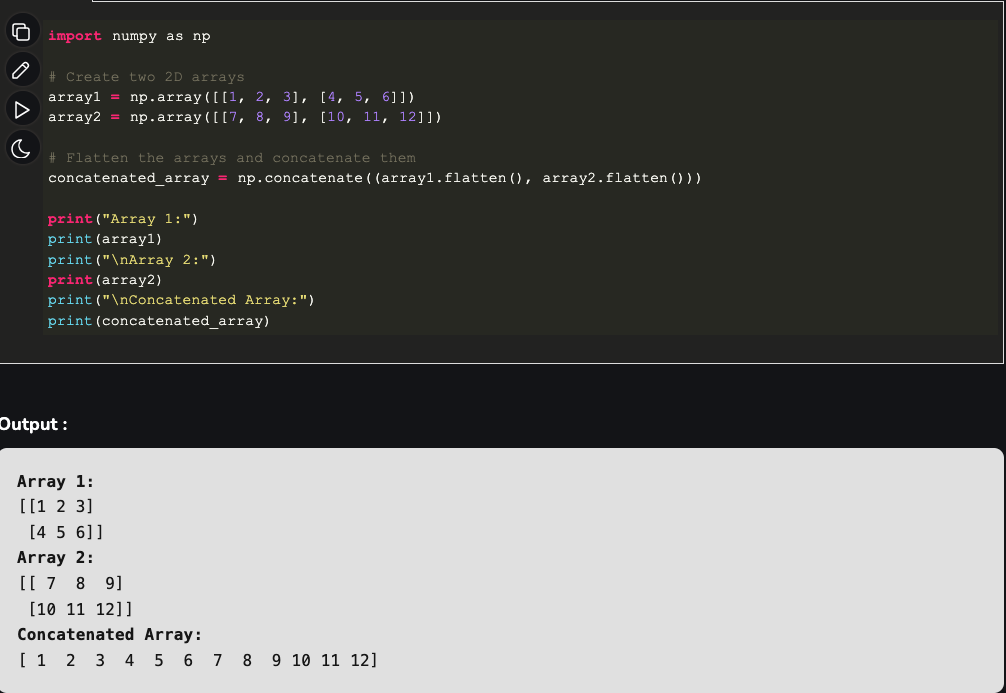

In [5]:
# https://www.geeksforgeeks.org/numpy-ndarray-flatten-function-python/
scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()

### Sequence Data Prepararion
Break the Data into Sequence

In [6]:
SEQUENCE_SIZE = 10
def to_sequence(seq_size, obs):
  x = []
  y = []
  for i in range(len(obs) - seq_size):
    window = obs[i:(i + seq_size)]
    after_window = obs[i+seq_size]
    x.append(window)
    y.append(after_window)
  return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1,1)

x_train, y_train = to_sequence(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequence(SEQUENCE_SIZE, spots_test)
x_test[1]

tensor([[-0.1521],
        [-0.0887],
        [ 0.1014],
        [ 0.2661],
        [ 0.4942],
        [ 0.4942],
        [ 0.3041],
        [ 0.3168],
        [ 0.1140],
        [ 0.5829]])

#### Set up data loaders for batch

In [7]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Positional Encoding For Transformers

In [11]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout=0.1, max_len=3000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))

    pe[:, 0::2] = torch.sin(position * div_term )
    pe[:, 1::2] =  torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0,1)

    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

# Constructing the transfomer model
Parameters:
* **input_dim** : The dimension of the input data
* **d_model** : The number of features in thransformer model's internal representation (also the size of the embeddings). This controls how much a model can remember and process.
* **nhead** : The number of attention heads
* **num_layers** : The number of transformer encoder layers
* **dropout**

In [18]:
# Model definition using Transformer
class TransformerModel(nn.Module):
  def __init__(self, input_dim=1, d_model=64, nhead=8, num_layers=2, dropout=0.2):
    super(TransformerModel, self).__init__()

    self.encoder = nn.Linear(input_dim, d_model)
    self.pos_encoder = PositionalEncoding(d_model, dropout)
    encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
    self.decoder = nn.Linear(d_model, 1)


  def forward(self, x):
    x = self.encoder(x)
    x = self.pos_encoder(x)
    x = self.transformer_encoder(x)
    x = self.decoder(x[:, -1, :])

In [19]:
model = TransformerModel().to(device)